In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
#import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
import os
from tensorflow import keras
from keras_tuner import RandomSearch
from tensorflow.keras import layers

In [2]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
df=pd.read_csv('database.csv')
df.head()

,wavelength,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles,vol_equi_radius_outer,vol_equi_radius_inner,equi_mobility_dia,mie_epsilon,length_scale_factor,...,q_sca,g,c_geo,c_ext,c_abs,c_sca,ssa,mac_total,mac_bc,mac_organics
0,660,1.5,0,15.0,1,15.000000,15.000000,23.829600,2,0.0952,...,0.000389,0.003798,706.858347,0.000083,0.000083,2.750000e-07,0.003318,3.897000,3.897000,0.0
1,660,1.5,0,15.0,2,18.898816,18.898816,33.934547,2,0.0952,...,0.001005,0.008979,1122.067684,0.000173,0.000172,1.130000e-06,0.006529,4.047873,4.047873,0.0
2,660,1.5,0,15.0,4,23.811016,23.811016,48.324498,2,0.0952,...,0.002514,0.022970,1781.171422,0.000362,0.000357,4.480000e-06,0.012376,4.212336,4.212336,0.0
3,660,1.5,0,15.0,6,27.256809,27.256809,59.425643,2,0.0952,...,0.004187,0.037044,2333.994837,0.000550,0.000541,9.770000e-06,0.017756,4.248847,4.248847,0.0
4,660,1.5,0,15.0,8,30.000000,30.000000,68.816510,2,0.0952,...,0.005988,0.051049,2827.433388,0.000745,0.000728,1.690000e-05,0.022730,4.291000,4.291000,0.0


In [4]:
X=df.iloc[:,:8]
Y=df.iloc[:,25:28]
Y.head()

,q_abs,q_sca,g
0,0.11691,0.000389,0.003798
1,0.15300,0.001005,0.008979
2,0.20060,0.002514,0.022970
3,0.23162,0.004187,0.037044
4,0.25746,0.005988,0.051049


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y_train.shape[1]

3

In [7]:
scaling_x=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)


Hyperparameters:
1. No of hideen layers
2. No of neurons in hidden layers
3. Learning rate

In [8]:
def build_model(hp):
    model=keras.Sequential()
    model.add(Input(shape= (X_train.shape[1],)))
    for i in range(hp.Int('num_layers', 3,10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=256,
                                           step=32),
                               activation='relu',
                               kernel_initializer= hp.Choice('kernel_initializer', ['normal','he_normal', 'he_uniform'])))
    model.add(layers.Dense(3, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3])),
        loss='mean_absolute_percentage_error',
        metrics=['mean_absolute_percentage_error'])
        
    return model
        
    
    

In [9]:
tuner=RandomSearch(build_model,
                  objective='val_mean_absolute_percentage_error',
                  max_trials=2,
                  executions_per_trial=1,
                   directory= 'project1',
                   project_name='random_split'
                  )

In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_initializer (Choice)
{'default': 'normal', 'conditions': [], 'values': ['normal', 'he_normal', 'he_uniform'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [11]:
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [12]:
tuner.search(X_train, Y_train, epochs=5, batch_size=32, validation_split = 0.2, callbacks=[es])

Trial 2 Complete [00h 00m 07s]
val_mean_absolute_percentage_error: 20.364294052124023

Best val_mean_absolute_percentage_error So Far: 20.364294052124023
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [14]:
summary=tuner.results_summary()

Results summary
Results in project1\random_split
Showing 10 best trials
Objective(name='val_mean_absolute_percentage_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 10
units_0: 192
kernel_initializer: he_uniform
units_1: 128
units_2: 128
learning_rate: 0.01
units_3: 192
units_4: 64
units_5: 64
units_6: 192
units_7: 160
units_8: 192
units_9: 96
Score: 20.364294052124023
Trial summary
Hyperparameters:
num_layers: 10
units_0: 128
kernel_initializer: normal
units_1: 64
units_2: 224
learning_rate: 0.001
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
Score: 21.62499237060547


NoneType

In [15]:
models = tuner.get_best_models(num_models=2)


In [16]:
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               1728      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                12352     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 192)               1

In [17]:
best_model_2= models[1]

best_model_2.build()
print(best_model_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 224)               14560     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                7200      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1

In [8]:
def build_model():
    model=Sequential()
    input_layer= Input(shape= (X_train.shape[1],))
    first_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(input_layer)
    second_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(first_dense)
    third_dense=Dense(units=224, kernel_initializer='normal', activation= 'relu')(second_dense)
    fourth_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(third_dense)
    fifth_dense=Dense(units=224, kernel_initializer='normal', activation= 'relu')(fourth_dense)
    sixth_dense=Dense(units=128, kernel_initializer='normal', activation= 'relu')(fifth_dense)
    seventh_dense=Dense(units=32, kernel_initializer='normal', activation= 'relu')(sixth_dense)
    eighth_dense=Dense(units=64, kernel_initializer='normal', activation= 'relu')(seventh_dense)
    output_dense=Dense(units=3, kernel_initializer='normal', activation= 'linear')(eighth_dense)
    #output_dense[:,0]=tf.keras.activations.sigmoid(output_dense[:,0])
    #output_q_abs=  tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,0:1])
    #output_q_sca= tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,1:2])
    #output_g= tf.keras.layers.Activation(tf.nn.sigmoid)(output_dense[:,2:3])
    #print(output_dense.shape)
   
    
    #model=tf.keras.Model(inputs=input_layer, outputs= [output_q_abs, output_q_sca, output_g])
    model=tf.keras.Model(inputs=input_layer, outputs= output_dense)
    
    return model
    
    

In [9]:
model= build_model()

#optimizer= tf.keras.optimizers.Adam(lr= 0.001)
# model.compile(optimizer='adam',
#              loss={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              },
#              metrics={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              })
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 224)               57568     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               57600     
_________________________________________________________________
dense_4 (Dense)              (None, 224)               57568     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               28800 

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


In [11]:
filepath="random_split_with_min_max/best_model.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

In [12]:
# # patient early stopping
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [13]:
log_csv=CSVLogger('random_split_loss_logs.csv', separator=',', append=False)

In [14]:
callback_list=[checkpoint, es, log_csv]

In [15]:
history= model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split = 0.2, callbacks=callback_list)
#history= NN_model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_split = 0.2)

Epoch 1/10
185/185 [==============================] - 6s 10ms/step - loss: 41.6953 - mean_absolute_percentage_error: 41.6953 - val_loss: 21.4986 - val_mean_absolute_percentage_error: 21.4986

Epoch 00001: val_loss improved from inf to 21.49858, saving model to random_split_with_min_max\best_model.hdf5
Epoch 2/10
185/185 [==============================] - 1s 6ms/step - loss: 19.6077 - mean_absolute_percentage_error: 19.6077 - val_loss: 17.5631 - val_mean_absolute_percentage_error: 17.5631

Epoch 00002: val_loss improved from 21.49858 to 17.56306, saving model to random_split_with_min_max\best_model.hdf5
Epoch 3/10
185/185 [==============================] - 1s 6ms/step - loss: 15.1931 - mean_absolute_percentage_error: 15.1931 - val_loss: 14.7054 - val_mean_absolute_percentage_error: 14.7054

Epoch 00003: val_loss improved from 17.56306 to 14.70544, saving model to random_split_with_min_max\best_model.hdf5
Epoch 4/10
185/185 [==============================] - 1s 6ms/step - loss: 9.7459 - 

In [17]:
# latest=tf.train.latest_checkpoint(checkpoint_dir)
weights_file = 'random_split_with_min_max/Weights-448--1.34756.hdf5' # choose the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [18]:
model.save('random_split_model.h5')

Train loss: 1.232, Validation loss: 1.394


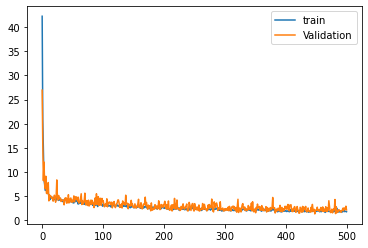

In [19]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train loss: %.3f, Validation loss: %.3f' % (train_loss, test_loss))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_percentage_error

In [21]:
Y_pred = model.predict(X_test)
#Y_pred[0]= pd.DataFrame(Y_pred[0], columns =['q_abs'])
#Y_pred[1]= pd.DataFrame(Y_pred[1], columns =['q_sca'])
#Y_pred[2]= pd.DataFrame(Y_pred[2], columns =['g'])
#predictions= pd.concat([Y_pred[0], Y_pred[1], Y_pred[2]], axis=1)
#predictions

In [22]:
error= mean_absolute_percentage_error(Y_test, Y_pred, multioutput='raw_values')   
print('Mean absolute percentage error on test set: ', error)

Mean absolute percentage error on test set:  [0.00773196 0.01796328 0.01612322]
